<a href="https://colab.research.google.com/github/cmyhre2/MLA2_CTM/blob/main/MLA2_CTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Machine Learning Assignment #2  
**Chris Myhre**  

## Standard Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Imports for specific models
In this section, you will import the models from SKLearn that you will use this in this notebook.

In [4]:
#example - you will replace this with the models you are actually using.
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression

## Imports for Splitting Data and Building Pipeline


In [5]:
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn import set_config
set_config(display='diagram')

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# Imports for Performance Measures

In [6]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import accuracy_score

## Confusion Matrix Function
This function is for creating a graphical version of the confusion matrix.



In [7]:
def plot_cm(y_test, y_pred):
    cm = confusion_matrix(y_test,y_pred)
    fig = plt.figure(figsize=(10,10))
    heatmap = sns.heatmap(cm, annot=True, fmt='.2f', cmap='RdYlGn')
    plt.ylabel('True label')
    plt.xlabel('Predicted Label')

# ROC_Curve Function
This function is for plotting the roc_curve

In [8]:
def plot_roc_curve(fpr,tpr):
  plt.plot(fpr, tpr, linewidth=2)
  plt.plot([0,1],[0,1], 'k--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.0])

## Problem 1

### Reading the Data

In [9]:
df = pd.read_csv('/content/drive/MyDrive/CS430/Assignment_2/Steel_industry_data.csv')

In [10]:
df=df.rename(columns={'Usage_kWh':'usage_kwh',
                      'Lagging_Current_Reactive.Power_kVarh':'lag_react_pwr_kvarh',
                      'Leading_Current_Reactive_Power_kVarh':'lead_react_pwr_kvarh',
                      'Lagging_Current_Power_Factor':'lag_current_pwr',
                      'Leading_Current_Power_Factor':'lead_current_pwr',
                      'NSM':'nsm',
                      'WeekStatus':'week_status',
                      'Day_of_week':'day_of_week',
                      'Load_Type':'load_type'})
df[:1]

,date,usage_kwh,lag_react_pwr_kvarh,lead_react_pwr_kvarh,CO2(tCO2),lag_current_pwr,lead_current_pwr,nsm,week_status,day_of_week,load_type
0,01/01/2018 00:15,3.17,2.95,0.0,0.0,73.21,100.0,900,Weekday,Monday,Light_Load


### Statistical and Visual Exploration

In [11]:
df.describe()

,usage_kwh,lag_react_pwr_kvarh,lead_react_pwr_kvarh,CO2(tCO2),lag_current_pwr,lead_current_pwr,nsm
count,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000
mean,27.386892,13.035384,3.870949,0.011524,80.578056,84.367870,42750.000000
std,33.444380,16.306000,7.424463,0.016151,18.921322,30.456535,24940.534317
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.200000,2.300000,0.000000,0.000000,63.320000,99.700000,21375.000000
50%,4.570000,5.000000,0.000000,0.000000,87.960000,100.000000,42750.000000
75%,51.237500,22.640000,2.090000,0.020000,99.022500,100.000000,64125.000000
max,157.180000,96.910000,27.760000,0.070000,100.000000,100.000000,85500.000000


In [12]:
df['load_type'].value_counts()

,count
load_type,
Light_Load,18072
Medium_Load,9696
Maximum_Load,7272


<Axes: xlabel='load_type', ylabel='count'>

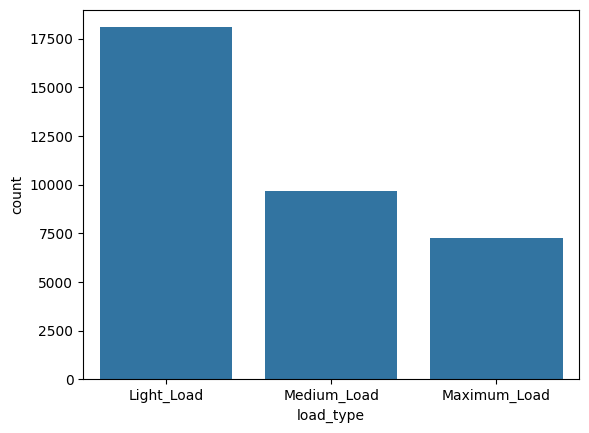

In [13]:
# create barplot
plt.figsize=(10,5)
sns.countplot(x='load_type', data=df)

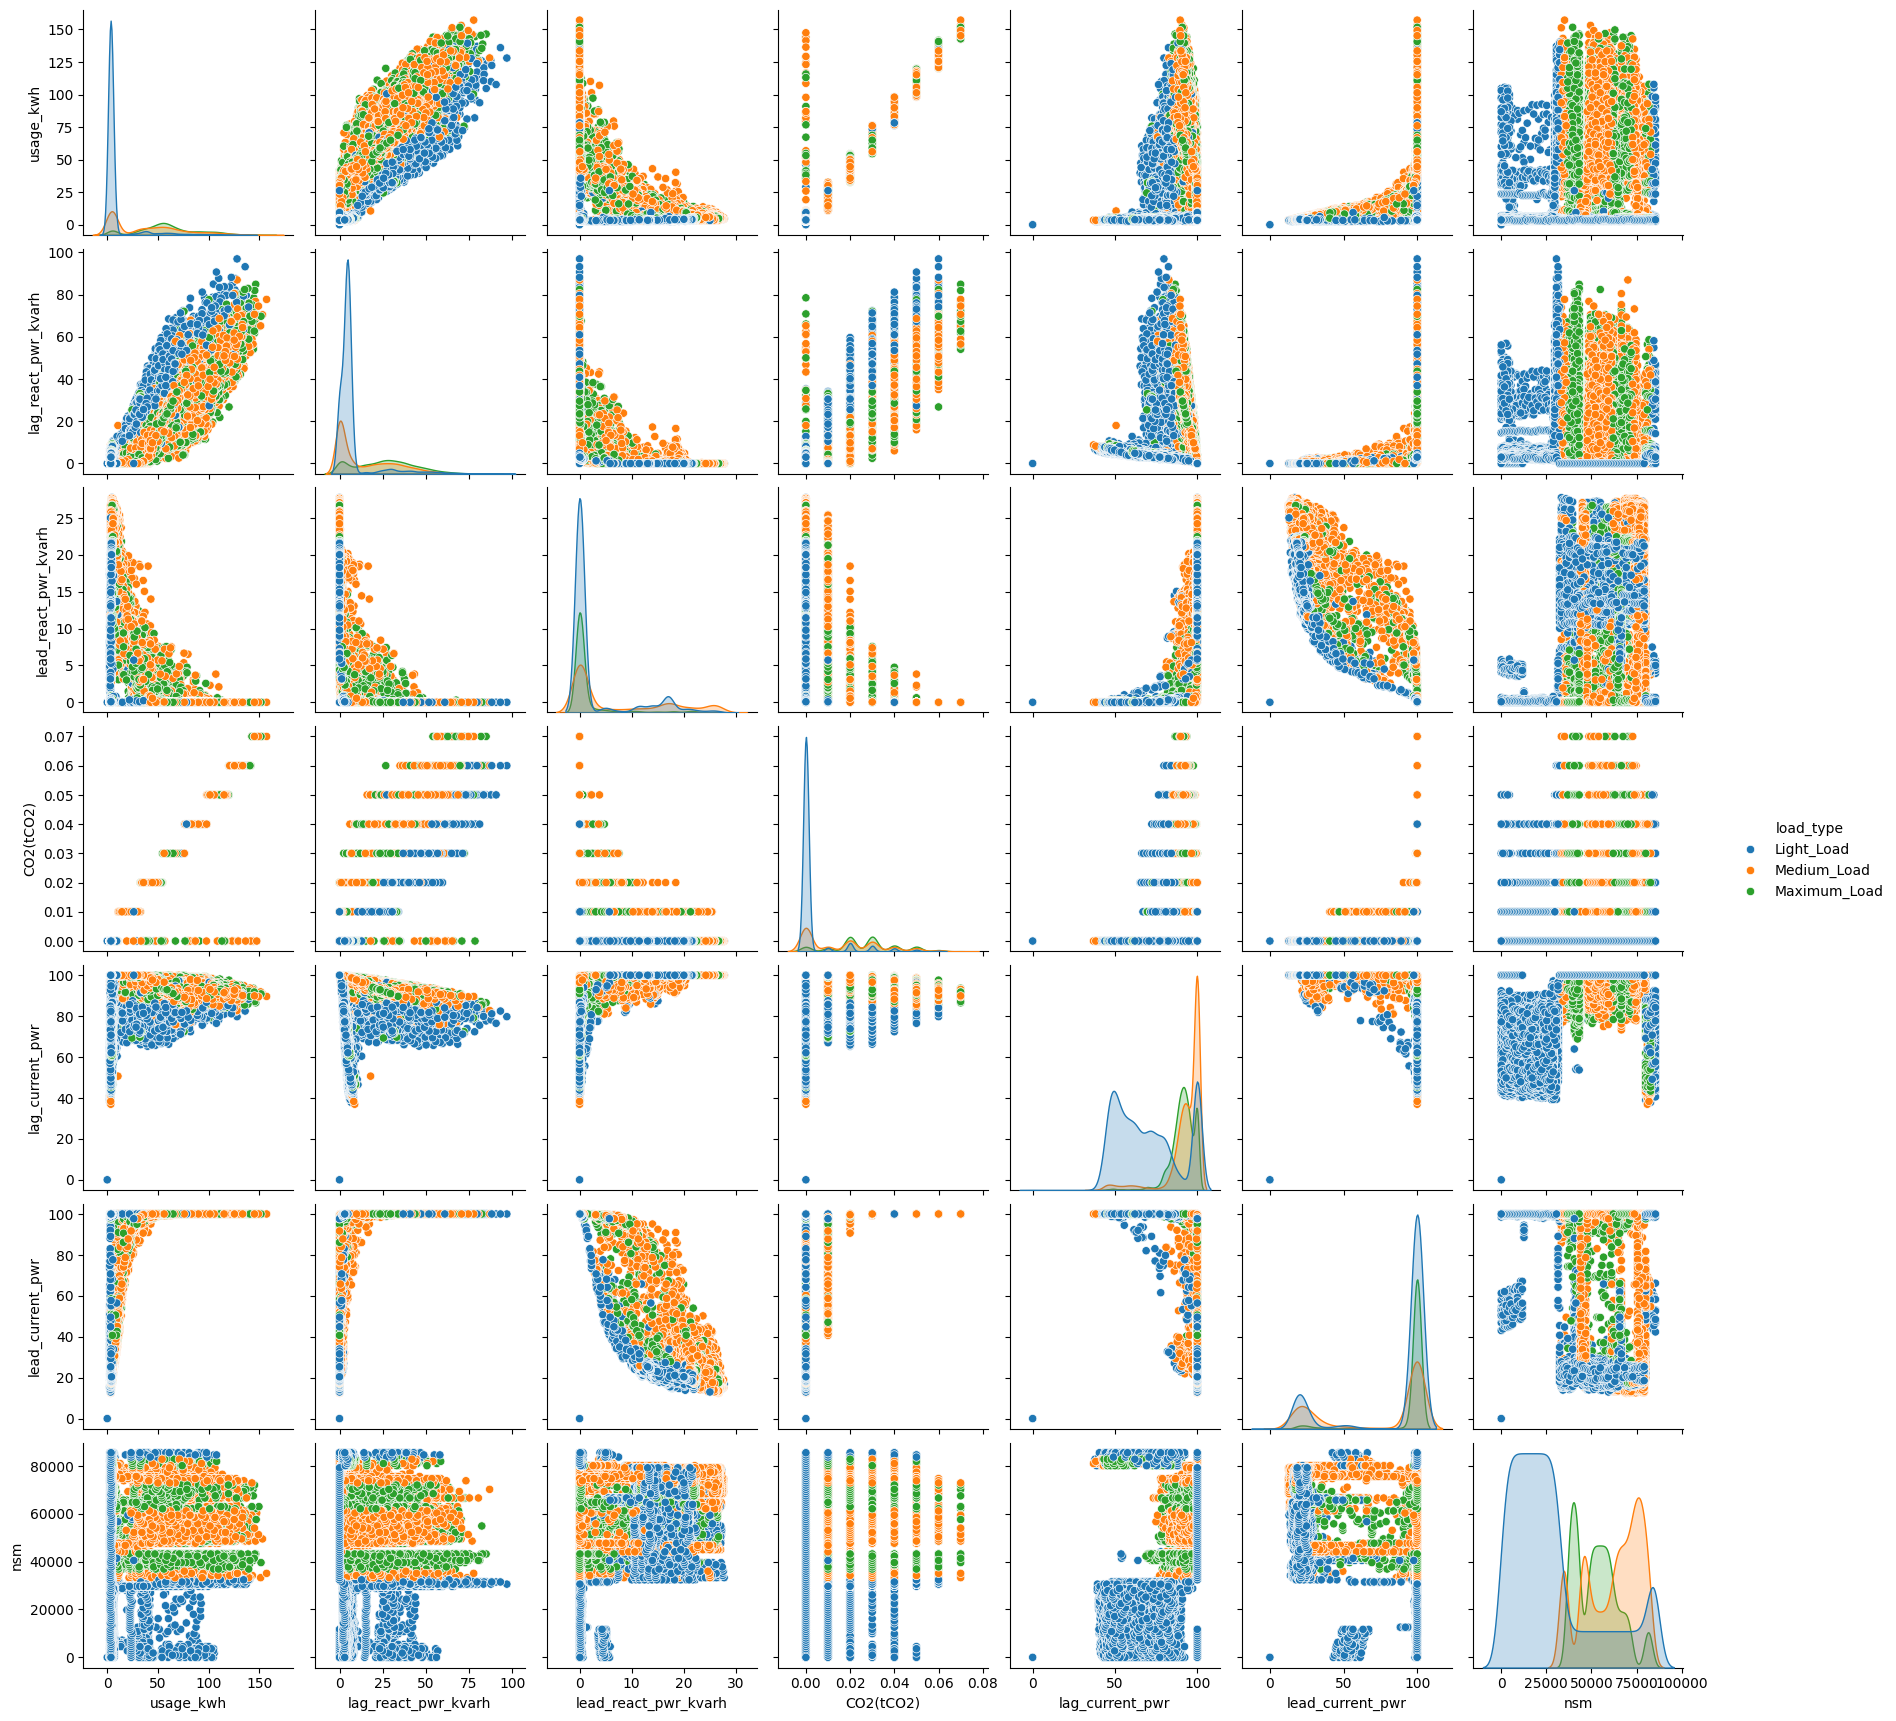

In [14]:
# create pairplot
sns.pairplot(df, hue='load_type')

### Plot Comments
By looking at the plots above, I can notice some patterns with the data. Some of these patterns are as follows:
- Higher kwh usuage correlates to higher lead current power<br>
- Higher kwh usage leads to higher CO2<br>
- lag_current_pwr tends to hover in high amounts no matter the usage_kwh<br>
- There is a negative assoiciation with lead_react_pwr_kvarh and lead_current_pwr<br>
- nsm and lag_current_pwr have no correlation<br>

### Splitting Data into Train/Test

In [15]:
X=pd.DataFrame(df.drop(['usage_kwh','date'], axis=1))
y=pd.DataFrame(df['usage_kwh'])

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Building the Pipeline

In [17]:
numerical_features=['lag_react_pwr_kvarh','lead_react_pwr_kvarh','CO2(tCO2)','lag_current_pwr','lead_current_pwr','nsm']
numerical_features=[]
categorical_features=['week_status','day_of_week','load_type']

In [18]:
# Preprocessing pipeline for numerical features
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Handle missing values
    ('scaler', StandardScaler())  # Standardize features
])

# Preprocessing pipeline for categorical features
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Handle missing values
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # One-hot encoding
])

# Combine preprocessing for both numerical and categorical features
preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_features),
    ('cat', categorical_transformer, categorical_features)
])

### Executing the Model

In [19]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
    # Fit the model
    model = model.fit(X_train, y_train)

    # Predict on test set
    y_pred = model.predict(X_test)

    # Evaluation metrics
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"Model: {model.named_steps['model'].__class__.__name__}")
    print(f"Mean Squared Error: {mse:.4f}")
    print(f"Root Mean Squared Error: {root_mean_squared_error(y_pred,y_test): 4f}")
    print(f"R² Score: {r2:.4f}")
    print('-' * 50)
    # Write the code to display the intercept value(bias)  and coefficients of the model. (These will be two different lines of code).

In [20]:
# Linear Regression Pipeline
linear_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])

### Evaluating Model

In [21]:
for model in [linear_pipeline]:
    evaluate_model(model, X_train, X_test, y_train, y_test)

Model: LinearRegression
Mean Squared Error: 676.2660
Root Mean Squared Error:  26.005115
R² Score: 0.4051
--------------------------------------------------


### Conclusion
The model seems to have a low r^2 value meaning only 40% of variance can be explained by the data meaning this model could use some improvement to handle more of the errors. With a low R^2 value, this model is bad at predicting kwh usage. A R^2 of 1 would be a perfect model but this model unfortunately 40% of that.

## Problem 2

### Logistic Regression - Acquire Data

In [22]:
df['week_status'] = df['week_status'].map({'Weekday': 1, 'Weekend': 0})

### Splitting Data into Train/Test

In [23]:
X = df.drop(['date', 'week_status', 'day_of_week'], axis=1)
y = df['week_status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Building the Pipeline

In [24]:
numerical_features = ['usage_kwh', 'lag_react_pwr_kvarh', 'lead_react_pwr_kvarh', 'CO2(tCO2)', 'lag_current_pwr', 'lead_current_pwr', 'nsm']
categorical_features = ['load_type']

# Preprocessing pipeline for numerical features
numerical_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())  # MinMax scale features
])

# Preprocessing pipeline for categorical features
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # One-hot encoding
])

# Combine preprocessing for both numerical and categorical features
preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_features),
    ('cat', categorical_transformer, categorical_features)
])

# Logistic Regression Pipeline
logistic_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LogisticRegression())
])


### Executing the Model

In [25]:
logistic_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['usage_kwh',
                                                   'lag_react_pwr_kvarh',
                                                   'lead_react_pwr_kvarh',
                                                   'CO2(tCO2)',
                                                   'lag_current_pwr',
                                                   'lead_current_pwr', 'nsm']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['load_type'])])),
                ('model', LogisticRegression())])

### Evaluating Model

Precision: 0.7754
Recall: 0.9624
F1 Score: 0.8588


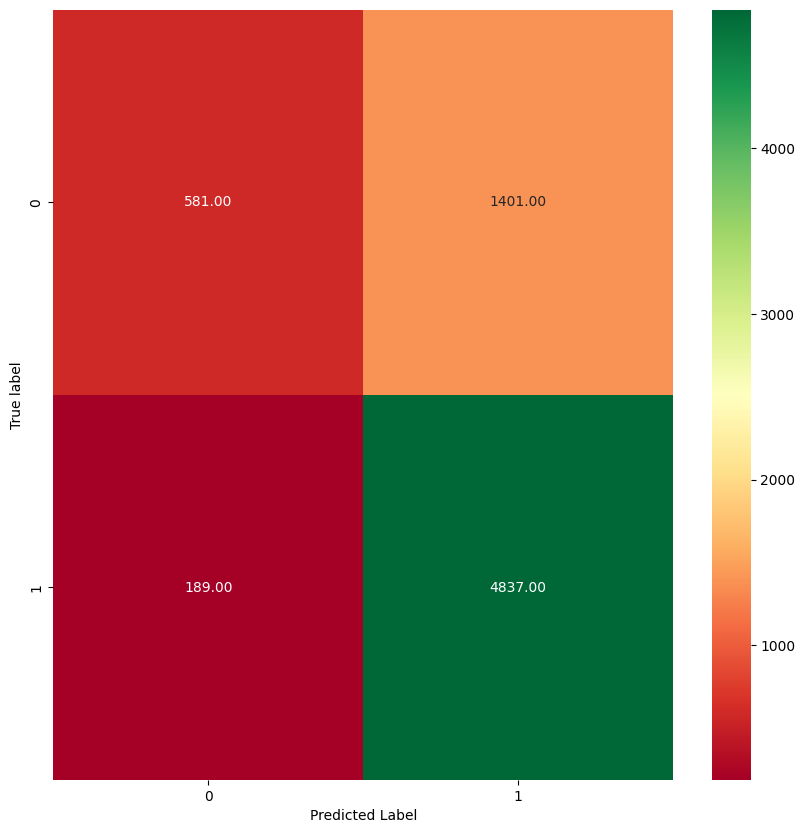

In [26]:
import matplotlib.pyplot as plt
y_pred = logistic_pipeline.predict(X_test)

plot_cm(y_test, y_pred)

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

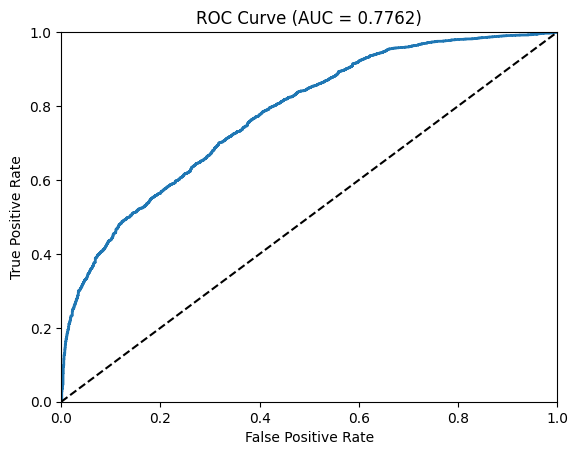

In [27]:
y_pred_proba = logistic_pipeline.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

plot_roc_curve(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (AUC = {:.4f})'.format(roc_auc))
plt.show()

# Interpretation of the results:
# (Write your interpretation here based on the confusion matrix, precision, recall, F1 score, and ROC curve.) <br>

The results seems to show that this model could use some tweaking but other than that it's pretty good, the precision (0.7754) brings this model down but has a decent F1 score of 0.8588 and recall of 0.9624. The ROC curve seems to cover most if not, all the data. The confusion matrix visializes the portion of the model that sinks it's accuracy score. The 0.2246 precision lost can be best seen by the false positives and false negatives in the matrix.

### Conclusion
I think this model is almost suited for predicting week_status. Wiith an accuracy score of 0.77 it's close to a passible score, I'd consider a passible scoring as 0.9 or 0.95.
